# patient-online-deprivation-score-model
#### Developed by: Mary Amanuel
#### Contact: mary.amanuel@nhsx.nhs.uk
#### Created: 22nd November 2021
#### Last updated: 22nd November 2021


In [134]:
import pandas as pd
import os
import plotly
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

### 'Public Health England. Public Health Profiles. [22/11/2021] https://fingertips.phe.org.uk © Crown copyright [2021]'
##### The English Indices of Deprivation 2019 - Technical documentation for data here: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833951/IoD2019_Technical_Report.pdf

##### The English Indices of Deprivation 2019 - Research documentation for data here: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833947/IoD2019_Research_Report.pdf

In [135]:
# Import fingertips_py package - This is a python package to interact with Public Health England’s [Fingertips](https://fingertips.phe.org.uk/) data tool. Fingertips is a major repository of population and public health indicators for England.
## https://fingertips-py.readthedocs.io/en/latest/#indices-and-table
## Installing the fingertips_py library (if not already)

!pip install fingertips_py
import fingertips_py

In [136]:
national_gp_profiles = fingertips_py.get_profile_by_name('National General Practice Profiles')
national_gp_profiles

{'Id': 21,
 'Name': 'National General Practice Profiles (supporting indicators)',
 'Key': 'practice-profiles-supporting-indicators',
 'GroupIds': [1200006],
 'GroupMetadata': [{'Id': 1200006,
   'Name': 'National GP Profiles - Supporting Indicators',
   'Sequence': 1,
   'ProfileId': 21,
   'DataAvailable': [{'AreaTypeId': 7, 'IndicatorCount': 20},
    {'AreaTypeId': 165, 'IndicatorCount': 20},
    {'AreaTypeId': 166, 'IndicatorCount': 20},
    {'AreaTypeId': 167, 'IndicatorCount': 20},
    {'AreaTypeId': 204, 'IndicatorCount': 20},
    {'AreaTypeId': 219, 'IndicatorCount': 20}]}],
 'Visualisations': ['Overview',
  'CompareAreas',
  'Trends',
  'AreaProfile',
  'Definitions',
  'Download'],
 'HasRecentTrends': False,
 'StartValueAxisFromZero': False,
 'IsChangeFromPreviousPeriodShown': False,
 'DefaultAreaTypeId': 7,
 'DefaultTabId': 0,
 'IgnoredSpineChartAreas': ['E06000053', 'E09000001'],
 'OpenInequalitiesOnAreaData': False}

In [137]:
## Check the relevant geographies that can be called upon as area id. For instance, it can be seen that 'General Practice' is 7
fingertips_py.metadata.get_area_types_as_dict()

[{'Name': 'Middle Super Output Area',
  'Short': 'MSOA',
  'Class': None,
  'CanBeDisplayedOnMap': True,
  'Id': 3},
 {'Name': 'Lower Super Output Area',
  'Short': 'LSOA',
  'Class': None,
  'CanBeDisplayedOnMap': False,
  'Id': 4},
 {'Name': 'Government Office Region',
  'Short': 'Region',
  'Class': None,
  'CanBeDisplayedOnMap': True,
  'Id': 6},
 {'Name': 'General Practice',
  'Short': 'GP',
  'Class': None,
  'CanBeDisplayedOnMap': True,
  'Id': 7},
 {'Name': 'Ward',
  'Short': 'Ward',
  'Class': None,
  'CanBeDisplayedOnMap': True,
  'Id': 8},
 {'Name': 'Acute Trust',
  'Short': 'Acute Trust',
  'Class': None,
  'CanBeDisplayedOnMap': False,
  'Id': 14},
 {'Name': 'England',
  'Short': 'England',
  'Class': None,
  'CanBeDisplayedOnMap': False,
  'Id': 15},
 {'Name': 'Mental Health Trust',
  'Short': 'Mental Health Trust',
  'Class': None,
  'CanBeDisplayedOnMap': False,
  'Id': 20},
 {'Name': 'Ambulance Trust',
  'Short': 'Ambulance Trust',
  'Class': None,
  'CanBeDisplayedOnM

In [138]:
# Obtain dataframe with metadata on metrics under chosen topic (can instead just navigate website direct)
national_gp_profiles_meta = fingertips_py.get_metadata_for_profile_as_dataframe(national_gp_profiles['Id'])
national_gp_profiles_meta

,Indicator ID,Indicator,Definition,Rationale,Data source,Indicator source,Methodology,Standard population/values,Confidence interval details,Source of numerator,...,Notes,Frequency,Rounding,Indicator Content,Specific rationale,Impact of COVID-19,Unit,Value type,Year type,Polarity
0,337,GP registered population by sex and quinary ag...,Number of males and females registered with a ...,NaN,NHS digital,Data for April of the respective calendar year...,NaN,NaN,NaN,NaN,...,Data are extracted as monthly snapshot in time...,NaN,NaN,NaN,NaN,NaN,NaN,Count,Calendar,Not applicable
1,114,QOF Total List Size,Total number of patients registered with the p...,NaN,"Quality and Outcomes Framework (QOF), NHS Digital",Data for 2019/20 can be downloaded from https...,NaN,NaN,NaN,"Quality and Outcomes Framework (QOF), NHS Digital",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Count,Financial,Not applicable
2,295,Total QOF points,The percentage of all QOF points achieved acro...,NaN,"Quality and Outcomes Framework (QOF), NHS Digital",Data for 2019/20 can be downloaded from https:...,NaN,NaN,NaN,"Quality and Outcomes Framework (QOF), NHS Digital",...,The maximal number of QOF points in 2013/14 wa...,NaN,NaN,NaN,NaN,NaN,%,Proportion,Financial,RAG - High is good
3,650,Life expectancy - MSOA based,Life expectancy at birth. Population weighting...,Life expectancy at birth is chosen as the pref...,"PHE, based on ONS mortality data",http://www.localhealth.org.uk for MSOA life ex...,The life expectancy for the MSOAs where the pr...,NaN,NaN,NaN,...,This indicator was initially calculated for MS...,NaN,NaN,NaN,NaN,NaN,Years,Life expectancy,Calendar,RAG - High is good
4,93438,% who have a positive experience of their GP p...,"Question 30. People were asked: ""Overall, how ...",NaN,GP Patient Survey,http://www.gp-patient.co.uk,NaN,NaN,NaN,NaN,...,The number of this question has changed from 3...,NaN,NaN,NaN,NaN,NaN,%,Proportion,Calendar,BOB - Blue orange blue
5,1679,Ethnicity estimates,Estimated proportion of non-white ethnic group...,NaN,Census 2011(Ethnicity by LSOA); HSCIC: Numbers...,Department of Primary Care and Public Health S...,NaN,NaN,NaN,NaN,...,If an ethnic group's proportion is smaller tha...,NaN,NaN,NaN,NaN,NaN,%,Proportion,Financial,Not applicable
6,93558,IDACI - Income Deprivation Affecting Children ...,This is a subset of the Income Deprivation Dom...,The Income Deprivation Affecting Children Inde...,"Ministry of Housing, Communities & Local Gover...",IDAOPI and IDACI are part of the English Indic...,Where area values have been published in the d...,NaN,NaN,NaN,...,NaN,The indices of deprivation are published in ir...,NaN,NaN,NaN,NaN,NaN,Proportion,Calendar,RAG - Low is good
7,93559,IDAOPI - Income Deprivation Affecting Older Pe...,This is a subset of the Income Deprivation Dom...,Deprivation is one of the strongest predictors...,"Ministry of Housing, Communities & Local Gover...",The IDACI and IDAOPI are part of the English I...,Where area values have been published in the d...,NaN,NaN,NaN,...,NaN,The indices of deprivation are published in ir...,NaN,NaN,NaN,NaN,NaN,Proportion,Calendar,RAG - Low is good
8,93553,Deprivation score (IMD 2019),The English Indices of Deprivation 2019 use 39...,Deprivation covers a broad range of issues and...,"Ministry of Housing, Communities & Local Gover...",https://www.gov.uk/government/statistics/engli...,The English Indices of Deprivation 2019 are me...,NaN,NaN,NaN,...,The Indices of Deprivation 2019 are relative m...,NaN,NaN,NaN,NaN,NaN,NaN,Score,Calendar,RAG - Low is good


In [139]:
gp_and_england_deprivation_score = fingertips_py.retrieve_data.get_data_by_indicator_ids(indicator_ids=[93553],area_type_id =[7] ) # 7 for practice (we know this topic area has practice breakdown for sure, by design), 93553 for our metric of interest
gp_and_england_deprivation_score

,Indicator ID,Indicator Name,Parent Code,Parent Name,Area Code,Area Name,Area Type,Sex,Age,Category Type,...,Upper CI 99.8 limit,Count,Denominator,Value note,Recent Trend,Compared to England value or percentiles,Column not used,Time period Sortable,New data,Compared to goal
0,93553,Deprivation score (IMD 2019),NaN,NaN,E92000001,England,England,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
1,93553,Deprivation score (IMD 2019),E92000001,England,A81001,The Densham Surgery,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
2,93553,Deprivation score (IMD 2019),E92000001,England,A81002,Queens Park Medical Centre,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
3,93553,Deprivation score (IMD 2019),E92000001,England,A81004,Bluebell Medical Centre,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
4,93553,Deprivation score (IMD 2019),E92000001,England,A81005,Springwood Surgery,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,93553,Deprivation score (IMD 2019),E92000001,England,Y05857,RHND,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
7604,93553,Deprivation score (IMD 2019),E92000001,England,Y06007,Wellbourne Healthcare CIC,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
7605,93553,Deprivation score (IMD 2019),E92000001,England,Y06113,QHS GP Care Home Service,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN
7606,93553,Deprivation score (IMD 2019),E92000001,England,Y06218,Brownsover Medical Centre,GP,Persons,All ages,NaN,...,NaN,NaN,NaN,NaN,Cannot be calculated,Not compared,Not compared,20190000,NaN,NaN


In [140]:
gp_and_england_deprivation_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Indicator ID                              7608 non-null   int64  
 1   Indicator Name                            7608 non-null   object 
 2   Parent Code                               7607 non-null   object 
 3   Parent Name                               7607 non-null   object 
 4   Area Code                                 7608 non-null   object 
 5   Area Name                                 7608 non-null   object 
 6   Area Type                                 7608 non-null   object 
 7   Sex                                       7608 non-null   object 
 8   Age                                       7608 non-null   object 
 9   Category Type                             0 non-null      float64
 10  Category                            

In [141]:
gp_and_england_deprivation_score = gp_and_england_deprivation_score[['Area Code', 'Area Name', 'Area Type', 'Time period', 'Value']]
gp_and_england_deprivation_score

,Area Code,Area Name,Area Type,Time period,Value
0,E92000001,England,England,2019,21.722087
1,A81001,The Densham Surgery,GP,2019,32.360939
2,A81002,Queens Park Medical Centre,GP,2019,31.921958
3,A81004,Bluebell Medical Centre,GP,2019,28.024026
4,A81005,Springwood Surgery,GP,2019,15.398207
...,...,...,...,...,...
7603,Y05857,RHND,GP,2019,23.386000
7604,Y06007,Wellbourne Healthcare CIC,GP,2019,44.559787
7605,Y06113,QHS GP Care Home Service,GP,2019,32.817919
7606,Y06218,Brownsover Medical Centre,GP,2019,15.623656


In [142]:
gp_deprivation_score_2019 = gp_and_england_deprivation_score[gp_and_england_deprivation_score['Area Type'].isin(['GP'])]
gp_deprivation_score_2019 = gp_deprivation_score_2019.rename(columns={'Area Code' :'Area_Code', 
                                          'Area Name' : 'GP_Name',
                                          'Area Type' : 'Area_Type',
                                          'Time period' : 'Time_Period', 
                                          'Value' : 'Deprivation_Score_IMD_2019'})
gp_deprivation_score_2019['GP_Name'] = gp_deprivation_score_2019['GP_Name'].str.upper()

In [143]:
gp_deprivation_score_2019

,Area_Code,GP_Name,Area_Type,Time_Period,Deprivation_Score_IMD_2019
1,A81001,THE DENSHAM SURGERY,GP,2019,32.360939
2,A81002,QUEENS PARK MEDICAL CENTRE,GP,2019,31.921958
3,A81004,BLUEBELL MEDICAL CENTRE,GP,2019,28.024026
4,A81005,SPRINGWOOD SURGERY,GP,2019,15.398207
5,A81006,TENNANT STREET MEDICAL PRACTICE,GP,2019,35.612387
...,...,...,...,...,...
7603,Y05857,RHND,GP,2019,23.386000
7604,Y06007,WELLBOURNE HEALTHCARE CIC,GP,2019,44.559787
7605,Y06113,QHS GP CARE HOME SERVICE,GP,2019,32.817919
7606,Y06218,BROWNSOVER MEDICAL CENTRE,GP,2019,15.623656


In [144]:
gp_deprivation_score_2019.describe()

,Time_Period,Deprivation_Score_IMD_2019
count,6980.0,6980.000000
mean,2019.0,23.530374
std,0.0,11.666802
min,2019.0,3.404973
25%,2019.0,14.089732
50%,2019.0,21.576292
75%,2019.0,30.878554
max,2019.0,68.721015


In [145]:
gp_deprivation_score_2019['GP_Rank'] = gp_deprivation_score_2019['Deprivation_Score_IMD_2019'].rank(ascending = False)
gp_deprivation_score_2019

,Area_Code,GP_Name,Area_Type,Time_Period,Deprivation_Score_IMD_2019,GP_Rank
1,A81001,THE DENSHAM SURGERY,GP,2019,32.360939,1520.0
2,A81002,QUEENS PARK MEDICAL CENTRE,GP,2019,31.921958,1587.0
3,A81004,BLUEBELL MEDICAL CENTRE,GP,2019,28.024026,2240.0
4,A81005,SPRINGWOOD SURGERY,GP,2019,15.398207,4884.0
5,A81006,TENNANT STREET MEDICAL PRACTICE,GP,2019,35.612387,1120.0
...,...,...,...,...,...,...
7603,Y05857,RHND,GP,2019,23.386000,3108.0
7604,Y06007,WELLBOURNE HEALTHCARE CIC,GP,2019,44.559787,416.0
7605,Y06113,QHS GP CARE HOME SERVICE,GP,2019,32.817919,1450.0
7606,Y06218,BROWNSOVER MEDICAL CENTRE,GP,2019,15.623656,4832.0


In [146]:
gp_deprivation_score_2019_ranking = gp_deprivation_score_2019.sort_values(by='GP_Rank', ascending=True)
gp_deprivation_score_2019_ranking['Percentile_Rank'] = gp_deprivation_score_2019.Deprivation_Score_IMD_2019.rank(pct = True)
gp_deprivation_score_2019_ranking

,Area_Code,GP_Name,Area_Type,Time_Period,Deprivation_Score_IMD_2019,GP_Rank,Percentile_Rank
6501,N82099,MERE LANE GROUP PRACTICE,GP,2019,68.721015,1.0,1.000000
62,A81621,THORNTREE SURGERY,GP,2019,67.407408,2.0,0.999857
6530,N82669,GREAT HOMER STREET MEDICAL CENTRE,GP,2019,65.248605,3.0,0.999713
6502,N82101,KIRKDALE,GP,2019,65.104433,4.0,0.999570
6523,N82651,STANLEY MEDICAL CENTRE,GP,2019,64.957030,5.0,0.999427
...,...,...,...,...,...,...,...
4968,K82049,HUGHENDEN VALLEY SURGERY,GP,2019,4.174575,6976.0,0.000716
4856,K81028,MAGNOLIA HOUSE SURGERY,GP,2019,4.158261,6977.0,0.000573
4662,J82099,RICHMOND SURGERY,GP,2019,4.151031,6978.0,0.000430
4899,K81092,WOOSEHILL PRACTICE,GP,2019,3.933291,6979.0,0.000287


In [147]:
gp_deprivation_score_2019_ranking['decile'] = pd.qcut(gp_deprivation_score_2019_ranking['Deprivation_Score_IMD_2019'], 10, labels=['10% least deprived', '20% least deprived', '30% least deprived', '40% least deprived', '50% least deprived', '50% most deprived', '40% most deprived', '30% most deprived', '20% most deprived', '10% most deprived'])
gp_deprivation_score_2019_ranking

,Area_Code,GP_Name,Area_Type,Time_Period,Deprivation_Score_IMD_2019,GP_Rank,Percentile_Rank,decile
6501,N82099,MERE LANE GROUP PRACTICE,GP,2019,68.721015,1.0,1.000000,10% most deprived
62,A81621,THORNTREE SURGERY,GP,2019,67.407408,2.0,0.999857,10% most deprived
6530,N82669,GREAT HOMER STREET MEDICAL CENTRE,GP,2019,65.248605,3.0,0.999713,10% most deprived
6502,N82101,KIRKDALE,GP,2019,65.104433,4.0,0.999570,10% most deprived
6523,N82651,STANLEY MEDICAL CENTRE,GP,2019,64.957030,5.0,0.999427,10% most deprived
...,...,...,...,...,...,...,...,...
4968,K82049,HUGHENDEN VALLEY SURGERY,GP,2019,4.174575,6976.0,0.000716,10% least deprived
4856,K81028,MAGNOLIA HOUSE SURGERY,GP,2019,4.158261,6977.0,0.000573,10% least deprived
4662,J82099,RICHMOND SURGERY,GP,2019,4.151031,6978.0,0.000430,10% least deprived
4899,K81092,WOOSEHILL PRACTICE,GP,2019,3.933291,6979.0,0.000287,10% least deprived


### Patient Online [December 2019]
##### Patient Online is an NHS England programme designed to support GP Practices to offer and promote online services to patients, including access to coded information in records, appointment booking and ordering of repeat prescriptions.

##### Data are provided by GP system suppliers to NHS Digital on a monthly basis and published on the 15th working day each month pending no issues, otherwise as soon as possible thereafter.

##### Data: https://digital.nhs.uk/data-and-information/data-collections-and-data-sets/data-collections/pomi

### Data dictionary
##### Pat_Appts_Use - Total number of appointment scheduling or cancelling transactions using an Online Patient Transaction Service.	Numeric (integer)

##### Pat_Presc_Use	- Total number of prescriptions ordered using an Online Patient Transaction Service. (Note that ordering several items at once to be counted as one prescription).	Numeric (integer)

##### Total_Use	- The total number of online transactions that have occurred within the reporting month.	Numeric (integer)

In [148]:
POMI = pd.read_csv('data/POMI_APR2019_to_MAR2020.csv', sep = ',')
POMI

,report_period_end,region_code,region_name,subregion_code,subregion_name,ccg_code,ccg_name,practice_code,practice_name,system_supplier,field,value
0,30APR2019,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS Hartlepool and Stockton-on-Tees CCG,A81632,LAWSON STREET PRACTICE,TPP,Pat_Appts_Enbld,0.0
1,30APR2019,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS Hartlepool and Stockton-on-Tees CCG,A81632,LAWSON STREET PRACTICE,TPP,Total_Pat_Enbld,0.0
2,30APR2019,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS Hartlepool and Stockton-on-Tees CCG,A81632,LAWSON STREET PRACTICE,TPP,Pat_Presc_Enbld,0.0
3,30APR2019,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS Hartlepool and Stockton-on-Tees CCG,A81632,LAWSON STREET PRACTICE,TPP,Total_Use,0.0
4,30APR2019,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS Hartlepool and Stockton-on-Tees CCG,A81632,LAWSON STREET PRACTICE,TPP,Pat_Appts_Use,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1052124,31MAR2020,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS North Tyneside CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Sys_Presc_Enbld,2.0
1052125,31MAR2020,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS North Tyneside CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Pat_Appts_Use,82.0
1052126,31MAR2020,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS North Tyneside CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Pat_Appts_Enbld,2172.0
1052127,31MAR2020,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS North Tyneside CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Sys_Appts_Enbld,2.0


In [149]:
POMI['report_period_end'] = pd.to_datetime(POMI['report_period_end'])
POMI['ccg_name'] = POMI['ccg_name'].replace(['NHS Herefordshire CCG'],'NHS Herefordshire and Worcestershire CCG')
POMI['ccg_name'] = POMI['ccg_name'].replace(['NHS Herts Valley CCG'],'NHS Herts Valleys CCG')
POMI['ccg_name'] = POMI['ccg_name'].str.upper()
POMI['practice_name'] = POMI['practice_name'].str.upper()
POMI

,report_period_end,region_code,region_name,subregion_code,subregion_name,ccg_code,ccg_name,practice_code,practice_name,system_supplier,field,value
0,2019-04-30,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,A81632,LAWSON STREET PRACTICE,TPP,Pat_Appts_Enbld,0.0
1,2019-04-30,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,A81632,LAWSON STREET PRACTICE,TPP,Total_Pat_Enbld,0.0
2,2019-04-30,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,A81632,LAWSON STREET PRACTICE,TPP,Pat_Presc_Enbld,0.0
3,2019-04-30,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,A81632,LAWSON STREET PRACTICE,TPP,Total_Use,0.0
4,2019-04-30,Y54,NaN,Q74,NHS ENGLAND NORTH (CUMBRIA AND NORTH EAST),00K,NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,A81632,LAWSON STREET PRACTICE,TPP,Pat_Appts_Use,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1052124,2020-03-31,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS NORTH TYNESIDE CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Sys_Presc_Enbld,2.0
1052125,2020-03-31,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS NORTH TYNESIDE CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Pat_Appts_Use,82.0
1052126,2020-03-31,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS NORTH TYNESIDE CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Pat_Appts_Enbld,2172.0
1052127,2020-03-31,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,Q74,NHS ENGLAND NORTH EAST AND YORKSHIRE (CUMBRIA ...,99C,NHS NORTH TYNESIDE CCG,A87612,WELLSPRING MEDICAL PRACT.,TPP,Sys_Appts_Enbld,2.0


In [150]:
POMI_pivot =  pd.pivot_table(POMI, index = ['report_period_end', 'practice_name', 'practice_code', 'region_code', ], columns = 'field', values = 'value')
POMI_pivot

field                                                                                 New_Pat_Enbld  \
report_period_end practice_name                            practice_code region_code                  
2019-04-30        (IRLAM) SALFORD CARE CTRS MEDICAL PRACTI P87657        Y62                   10.0   
                  1/LOWER BROUGHTON MEDICAL PRACTICE       P87652        Y62                    1.0   
                  1/MONTON MEDICAL PRACTICE                P87620        Y62                   46.0   
                  1/SALFORD MEDICAL PRACTICE               P87004        Y62                    2.0   
                  108 RAWLING ROAD(RAWLING ROAD PRACTICE)  A85609        Y63                    5.0   
...                                                                                             ...   
2020-03-31        YORKSHIRE STREET MEDICAL CENTRE          P81008        Y62                   59.0   
                  YOXALL                                   M83013        Y60                   16.0   
                  ZAIN MEDICAL CENTRE                      E84653        Y56                   18.0   
                  ZAMAN                                    P92005        Y62                   31.0   
                  ZETLAND MEDICAL PRACTICE                 A81048        Y63                   98.0   

field                                                                                 Pat_Appts_Enbld  \
report_period_end practice_name                            practice_code region_code                    
2019-04-30        (IRLAM) SALFORD CARE CTRS MEDICAL PRACTI P87657        Y62                    594.0   
                  1/LOWER BROUGHTON MEDICAL PRACTICE       P87652        Y62                    380.0   
                  1/MONTON MEDICAL PRACTICE                P87620        Y62                   3703.0   
                  1/SALFORD MEDICAL PRACTICE               P87004        Y62                    568.0   
                  108 RAWLING ROAD(RAWLING ROAD PRACTICE)  A85609        Y63                    252.0   
...                                                                                               ...   
2020-03-31        YORKSHIRE STREET MEDICAL CENTRE          P81008        Y62                   1811.0   
                  YOXALL                                   M83013        Y60                   2235.0   
                  ZAIN MEDICAL CENTRE                      E84653        Y56                    727.0   
                  ZAMAN                                    P92005        Y62                    968.0   
                  ZETLAND MEDICAL PRACTICE                 A81048        Y63                   1523.0   

field                                                                                 Pat_Appts_Use  \
report_period_end practice_name                            practice_code region_code                  
2019-04-30        (IRLAM) SALFORD CARE CTRS MEDICAL PRACTI P87657        Y62                   12.0   
                  1/LOWER BROUGHTON MEDICAL PRACTICE       P87652        Y62                   17.0   
                  1/MONTON MEDICAL PRACTICE                P87620        Y62                  197.0   
                  1/SALFORD MEDICAL PRACTICE               P87004        Y62                    1.0   
                  108 RAWLING ROAD(RAWLING ROAD PRACTICE)  A85609        Y63                    0.0   
...                                                                                             ...   
2020-03-31        YORKSHIRE STREET MEDICAL CENTRE          P81008        Y62                   61.0   
                  YOXALL                                   M83013        Y60                   21.0   
                  ZAIN MEDICAL CENTRE                      E84653        Y56                   26.0   
                  ZAMAN                                    P92005        Y62                   38.0   
                  ZETLAND MEDICAL PRACTICE                

In [151]:
POMI_filter = POMI_pivot.drop(['New_Pat_Enbld','Pat_Appts_Enbld', 'Pat_DetCodeRec_Enbld','Pat_DetCodeRec_Use','Pat_Presc_Enbld','Sys_Appts_Enbld','Sys_DetCodeRec_Enbld','Sys_Presc_Enbld','Total_Pat_Enbld'], axis=1)
POMI_filter = POMI_filter.reset_index()
POMI_filter

field,report_period_end,practice_name,practice_code,region_code,Pat_Appts_Use,Pat_Presc_Use,Total_Use,patient_list_size
0,2019-04-30,(IRLAM) SALFORD CARE CTRS MEDICAL PRACTI,P87657,Y62,12.0,92.0,NaN,2851.0
1,2019-04-30,1/LOWER BROUGHTON MEDICAL PRACTICE,P87652,Y62,17.0,173.0,NaN,2146.0
2,2019-04-30,1/MONTON MEDICAL PRACTICE,P87620,Y62,197.0,414.0,NaN,9382.0
3,2019-04-30,1/SALFORD MEDICAL PRACTICE,P87004,Y62,1.0,182.0,NaN,3757.0
4,2019-04-30,108 RAWLING ROAD(RAWLING ROAD PRACTICE),A85609,Y63,0.0,4.0,4.0,1574.0
...,...,...,...,...,...,...,...,...
80928,2020-03-31,YORKSHIRE STREET MEDICAL CENTRE,P81008,Y62,61.0,634.0,1138.0,6269.0
80929,2020-03-31,YOXALL,M83013,Y60,21.0,876.0,1177.0,4740.0
80930,2020-03-31,ZAIN MEDICAL CENTRE,E84653,Y56,26.0,73.0,311.0,2989.0
80931,2020-03-31,ZAMAN,P92005,Y62,38.0,472.0,592.0,4178.0


In [152]:
patient_list_size_check = POMI_filter[['report_period_end','patient_list_size']].groupby('report_period_end').sum()
patient_list_size_check 

field,patient_list_size
report_period_end,
2019-04-30,59036151.0
2019-05-31,59097924.0
2019-06-30,59256719.0
2019-07-31,59322296.0
2019-08-31,59428950.0
2019-09-30,59490839.0
2019-10-31,59649310.0
2019-11-30,59756044.0
2019-12-31,59854026.0


In [153]:
POMI_filter['report_period_end'] = pd.to_datetime(POMI_filter['report_period_end'])
POMI_filter

field,report_period_end,practice_name,practice_code,region_code,Pat_Appts_Use,Pat_Presc_Use,Total_Use,patient_list_size
0,2019-04-30,(IRLAM) SALFORD CARE CTRS MEDICAL PRACTI,P87657,Y62,12.0,92.0,NaN,2851.0
1,2019-04-30,1/LOWER BROUGHTON MEDICAL PRACTICE,P87652,Y62,17.0,173.0,NaN,2146.0
2,2019-04-30,1/MONTON MEDICAL PRACTICE,P87620,Y62,197.0,414.0,NaN,9382.0
3,2019-04-30,1/SALFORD MEDICAL PRACTICE,P87004,Y62,1.0,182.0,NaN,3757.0
4,2019-04-30,108 RAWLING ROAD(RAWLING ROAD PRACTICE),A85609,Y63,0.0,4.0,4.0,1574.0
...,...,...,...,...,...,...,...,...
80928,2020-03-31,YORKSHIRE STREET MEDICAL CENTRE,P81008,Y62,61.0,634.0,1138.0,6269.0
80929,2020-03-31,YOXALL,M83013,Y60,21.0,876.0,1177.0,4740.0
80930,2020-03-31,ZAIN MEDICAL CENTRE,E84653,Y56,26.0,73.0,311.0,2989.0
80931,2020-03-31,ZAMAN,P92005,Y62,38.0,472.0,592.0,4178.0


In [154]:
POMI_filter.dtypes

field
report_period_end    datetime64[ns]
practice_name                object
practice_code                object
region_code                  object
Pat_Appts_Use               float64
Pat_Presc_Use               float64
Total_Use                   float64
patient_list_size           float64
dtype: object

In [155]:
POMI_dec_2019 = POMI_filter[POMI_filter['report_period_end'] == '2019-12-31']
POMI_dec_2019 

field,report_period_end,practice_name,practice_code,region_code,Pat_Appts_Use,Pat_Presc_Use,Total_Use,patient_list_size
54139,2019-12-31,(IRLAM) SALFORD CARE CTRS MEDICAL PRACTI,P87657,Y62,10.0,101.0,NaN,2822.0
54140,2019-12-31,1/MONTON MEDICAL PRACTICE,P87620,Y62,93.0,419.0,NaN,9466.0
54141,2019-12-31,1/SALFORD MEDICAL PRACTICE,P87004,Y62,0.0,174.0,NaN,3701.0
54142,2019-12-31,108 RAWLING ROAD(RAWLING ROAD PRACTICE),A85609,Y63,0.0,6.0,6.0,1442.0
54143,2019-12-31,15 SEFTON ROAD,N84035,Y62,14.0,254.0,455.0,4370.0
...,...,...,...,...,...,...,...,...
60848,2019-12-31,YORKSHIRE STREET MEDICAL CENTRE,P81008,Y62,129.0,521.0,1028.0,6231.0
60849,2019-12-31,YOXALL,M83013,Y60,72.0,662.0,984.0,4767.0
60850,2019-12-31,ZAIN MEDICAL CENTRE,E84653,Y56,55.0,61.0,329.0,2957.0
60851,2019-12-31,ZAMAN,P92005,Y62,95.0,338.0,441.0,4180.0


In [156]:
POMI_dec_2019_gp = POMI_dec_2019 [['practice_name', 'practice_code', 'Pat_Appts_Use', 'Pat_Presc_Use', 'Total_Use', 'patient_list_size']].groupby(['practice_code', 'practice_name']).sum()
POMI_dec_2019_gp = POMI_dec_2019_gp.reset_index()


In [157]:
POMI_dec_2019_gp

field,practice_code,practice_name,Pat_Appts_Use,Pat_Presc_Use,Total_Use,patient_list_size
0,A81001,THE DENSHAM SURGERY,31.0,751.0,994.0,4097.0
1,A81002,QUEENS PARK MEDICAL CENTRE,625.0,3294.0,4774.0,19304.0
2,A81004,BLUEBELL MEDICAL CENTRE,226.0,1255.0,1701.0,10940.0
3,A81005,SPRINGWOOD SURGERY,211.0,682.0,1254.0,8099.0
4,A81006,TENNANT STREET MEDICAL PRACTICE,418.0,2809.0,3396.0,14779.0
...,...,...,...,...,...,...
6709,Y06356,BILBOROUGH MEDICAL CENTRE,235.0,255.0,583.0,9752.0
6710,Y06378,HEATH STREET HEALTH CENTRE,9.0,9.0,48.0,6222.0
6711,Y06443,WHYBURN MEDICAL PRACTICE,408.0,1363.0,1868.0,11669.0
6712,Y06487,BABYLON GP AT HAND BIRMINGHAM,0.0,0.0,0.0,2.0


In [158]:
patient_list_size_check_ccg = POMI_dec_2019_gp['patient_list_size'].sum()
patient_list_size_check_ccg

59854026.0

### Use of Patient Online Per 1000 Patients

In [159]:
GP_POMI_IMD_2019 = gp_deprivation_score_2019_ranking.merge(POMI_dec_2019_gp_per_1000, how='inner', left_on='Area_Code', right_on ='practice_code')

In [160]:
POMI_dec_2019_gp['Pat_Presc_Use_per_1000'] = (POMI_dec_2019_gp['Pat_Presc_Use'] / POMI_dec_2019_gp['patient_list_size']) * 1000
POMI_dec_2019_gp['Pat_Appts_Use_per_1000'] = (POMI_dec_2019_gp['Pat_Appts_Use'] / POMI_dec_2019_gp['patient_list_size']) * 1000
POMI_dec_2019_gp_per_1000 = POMI_dec_2019_gp.round(2)
POMI_dec_2019_gp_per_1000

field,practice_code,practice_name,Pat_Appts_Use,Pat_Presc_Use,Total_Use,patient_list_size,Pat_Presc_Use_per_1000,Pat_Appts_Use_per_1000
0,A81001,THE DENSHAM SURGERY,31.0,751.0,994.0,4097.0,183.30,7.57
1,A81002,QUEENS PARK MEDICAL CENTRE,625.0,3294.0,4774.0,19304.0,170.64,32.38
2,A81004,BLUEBELL MEDICAL CENTRE,226.0,1255.0,1701.0,10940.0,114.72,20.66
3,A81005,SPRINGWOOD SURGERY,211.0,682.0,1254.0,8099.0,84.21,26.05
4,A81006,TENNANT STREET MEDICAL PRACTICE,418.0,2809.0,3396.0,14779.0,190.07,28.28
...,...,...,...,...,...,...,...,...
6709,Y06356,BILBOROUGH MEDICAL CENTRE,235.0,255.0,583.0,9752.0,26.15,24.10
6710,Y06378,HEATH STREET HEALTH CENTRE,9.0,9.0,48.0,6222.0,1.45,1.45
6711,Y06443,WHYBURN MEDICAL PRACTICE,408.0,1363.0,1868.0,11669.0,116.81,34.96
6712,Y06487,BABYLON GP AT HAND BIRMINGHAM,0.0,0.0,0.0,2.0,0.00,0.00


### Joining English Indices of Deprivation 2019 dataframe with Patient Online dataframe

In [161]:
GP_POMI_IMD_2019 = gp_deprivation_score_2019_ranking.merge(POMI_dec_2019_gp_per_1000, left_on='Area_Code', right_on ='practice_code')
GP_POMI_IMD_2019

,Area_Code,GP_Name,Area_Type,Time_Period,Deprivation_Score_IMD_2019,GP_Rank,Percentile_Rank,decile,practice_code,practice_name,Pat_Appts_Use,Pat_Presc_Use,Total_Use,patient_list_size,Pat_Presc_Use_per_1000,Pat_Appts_Use_per_1000
0,N82099,MERE LANE GROUP PRACTICE,GP,2019,68.721015,1.0,1.000000,10% most deprived,N82099,MERE LANE GROUP PRACTICE,28.0,392.0,681.0,7942.0,49.36,3.53
1,A81621,THORNTREE SURGERY,GP,2019,67.407408,2.0,0.999857,10% most deprived,A81621,THORNTREE SURGERY,36.0,57.0,124.0,2358.0,24.17,15.27
2,N82669,GREAT HOMER STREET MEDICAL CENTRE,GP,2019,65.248605,3.0,0.999713,10% most deprived,N82669,GREAT HOMER STREET MEDICAL CENTRE,79.0,263.0,544.0,3277.0,80.26,24.11
3,N82101,KIRKDALE,GP,2019,65.104433,4.0,0.999570,10% most deprived,N82101,KIRKDALE MEDICAL CENTRE,12.0,135.0,232.0,2714.0,49.74,4.42
4,N82651,STANLEY MEDICAL CENTRE,GP,2019,64.957030,5.0,0.999427,10% most deprived,N82651,STANLEY MEDICAL CENTRE,11.0,115.0,223.0,4544.0,25.31,2.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703,K82049,HUGHENDEN VALLEY SURGERY,GP,2019,4.174575,6976.0,0.000716,10% least deprived,K82049,HUGHENDEN VALLEY SURGERY,194.0,1777.0,2213.0,12631.0,140.69,15.36
6704,K81028,MAGNOLIA HOUSE SURGERY,GP,2019,4.158261,6977.0,0.000573,10% least deprived,K81028,MAGNOLIA HOUSE SURGERY,109.0,337.0,673.0,8980.0,37.53,12.14
6705,J82099,RICHMOND SURGERY,GP,2019,4.151031,6978.0,0.000430,10% least deprived,J82099,RICHMOND SURGERY,235.0,738.0,1264.0,14130.0,52.23,16.63
6706,K81092,WOOSEHILL PRACTICE,GP,2019,3.933291,6979.0,0.000287,10% least deprived,K81092,WOOSEHILL PRACTICE,161.0,801.0,1172.0,13601.0,58.89,11.84


In [162]:
GP_POMI_IMD_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6708 entries, 0 to 6707
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Area_Code                   6708 non-null   object  
 1   GP_Name                     6708 non-null   object  
 2   Area_Type                   6708 non-null   object  
 3   Time_Period                 6708 non-null   int64   
 4   Deprivation_Score_IMD_2019  6708 non-null   float64 
 5   GP_Rank                     6708 non-null   float64 
 6   Percentile_Rank             6708 non-null   float64 
 7   decile                      6708 non-null   category
 8   practice_code               6708 non-null   object  
 9   practice_name               6708 non-null   object  
 10  Pat_Appts_Use               6708 non-null   float64 
 11  Pat_Presc_Use               6708 non-null   float64 
 12  Total_Use                   6708 non-null   float64 
 13  patient_list_size 

#### These GP practices are missing from Fingertips / The English Indices of Deprivation 2019 Dataframe so are exlucded from our analysis

In [163]:
missing_gps = pd.merge(POMI_dec_2019_gp_per_1000, 
                    GP_POMI_IMD_2019,
                     how = 'outer',
                     left_on = 'practice_code',
                     right_on = 'Area_Code', 
                     indicator = True)

deleted_rows = missing_gps.loc[missing_gps._merge == "left_only",]
deleted_rows

,practice_code_x,practice_name_x,Pat_Appts_Use_x,Pat_Presc_Use_x,Total_Use_x,patient_list_size_x,Pat_Presc_Use_per_1000_x,Pat_Appts_Use_per_1000_x,Area_Code,GP_Name,...,decile,practice_code_y,practice_name_y,Pat_Appts_Use_y,Pat_Presc_Use_y,Total_Use_y,patient_list_size_y,Pat_Presc_Use_per_1000_y,Pat_Appts_Use_per_1000_y,_merge
6708,Y06345,BROMLEAG CARE PRACTICE,0.0,429.0,455.0,1229.0,349.06,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6709,Y06356,BILBOROUGH MEDICAL CENTRE,235.0,255.0,583.0,9752.0,26.15,24.10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6710,Y06378,HEATH STREET HEALTH CENTRE,9.0,9.0,48.0,6222.0,1.45,1.45,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6711,Y06443,WHYBURN MEDICAL PRACTICE,408.0,1363.0,1868.0,11669.0,116.81,34.96,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6712,Y06487,BABYLON GP AT HAND BIRMINGHAM,0.0,0.0,0.0,2.0,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6713,Y06507,PEACOCK HEALTHCARE,290.0,257.0,581.0,5559.0,46.23,52.17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


#### Deprivation_Score_IMD_2019 vs Pat_Presc_Use_per_1000

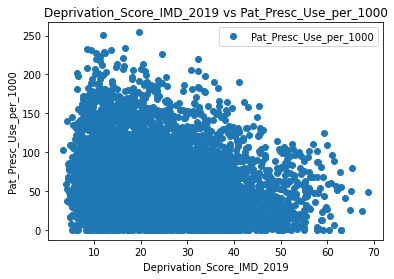

In [164]:
GP_POMI_IMD_2019.plot(x='Deprivation_Score_IMD_2019', y='Pat_Presc_Use_per_1000', style='o')  
plt.title('Deprivation_Score_IMD_2019 vs Pat_Presc_Use_per_1000')  
plt.xlabel('Deprivation_Score_IMD_2019')  
plt.ylabel('Pat_Presc_Use_per_1000')  
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.tight_layout()
seabornInstance.displot(GP_POMI_IMD_2019['Deprivation_Score_IMD_2019'])

<Figure size 1440x720 with 0 Axes>

In [ ]:
X = GP_POMI_IMD_2019['Deprivation_Score_IMD_2019'].values.reshape(-1,1)
y = GP_POMI_IMD_2019['Pat_Presc_Use_per_1000'].values.reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

In [ ]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
actual_vs_predicted = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
actual_vs_predicted

In [ ]:
actual_vs_predicted_viz= actual_vs_predicted.head(25)
actual_vs_predicted_viz.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Deprivation_Score_IMD_2019 vs Pat_Appt_Use_per_1000

In [ ]:
GP_POMI_IMD_2019.plot(x='Deprivation_Score_IMD_2019', y='Pat_Appts_Use_per_1000', style='o')  
plt.title('Deprivation_Score_IMD_2019 vs Pat_Appts_Use_per_1000')  
plt.xlabel('Deprivation_Score_IMD_2019')  
plt.ylabel('Pat_Appts_Use_per_1000')  
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.tight_layout()
seabornInstance.displot(GP_POMI_IMD_2019['Deprivation_Score_IMD_2019'])

In [ ]:
X = GP_POMI_IMD_2019['Deprivation_Score_IMD_2019'].values.reshape(-1,1)
y = GP_POMI_IMD_2019['Pat_Appts_Use_per_1000'].values.reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

In [ ]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
actual_vs_predicted = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
actual_vs_predicted

In [ ]:
actual_vs_predicted_viz= actual_vs_predicted.head(25)
actual_vs_predicted_viz.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))